# 梯度消失、梯度爆炸以及Kaggle房价预测

1. 梯度消失和梯度爆炸
2. 考虑到环境因素的其他问题
3. Kaggle房价预测

# 梯度消失和梯度爆炸

深度模型有关数值稳定性的典型问题是消失（vanishing）和爆炸（explosion）。

**当神经网络的层数较多时，模型的数值稳定性容易变差。**

假设一个层数为$L$的多层感知机的第$l$层$\boldsymbol{H}^{(l)}$的权重参数为$\boldsymbol{W}^{(l)}$，输出层$\boldsymbol{H}^{(L)}$的权重参数为$\boldsymbol{W}^{(L)}$。为了便于讨论，不考虑偏差参数，且设所有隐藏层的激活函数为恒等映射（identity mapping）$\phi(x) = x$。给定输入$\boldsymbol{X}$，多层感知机的第$l$层的输出$\boldsymbol{H}^{(l)} = \boldsymbol{X} \boldsymbol{W}^{(1)} \boldsymbol{W}^{(2)} \ldots \boldsymbol{W}^{(l)}$。此时，如果层数$l$较大，$\boldsymbol{H}^{(l)}$的计算可能会出现衰减或爆炸。举个例子，假设输入和所有层的权重参数都是标量，如权重参数为0.2和5，多层感知机的第30层输出为输入$\boldsymbol{X}$分别与$0.2^{30} \approx 1 \times 10^{-21}$（消失）和$5^{30} \approx 9 \times 10^{20}$（爆炸）的乘积。当层数较多时，梯度的计算也容易出现消失或爆炸。

# 随机初始化模型参数

在神经网络中，通常需要随机初始化模型参数。下面我们来解释这样做的原因。

回顾多层感知机一节描述的多层感知机。为了方便解释，假设输出层只保留一个输出单元$o_1$（删去$o_2$和$o_3$以及指向它们的箭头），且隐藏层使用相同的激活函数。如果将每个隐藏单元的参数都初始化为相等的值，那么在正向传播时每个隐藏单元将根据相同的输入计算出相同的值，并传递至输出层。在反向传播中，每个隐藏单元的参数梯度值相等。因此，这些参数在使用基于梯度的优化算法迭代后值依然相等。之后的迭代也是如此。在这种情况下，无论隐藏单元有多少，隐藏层本质上只有1个隐藏单元在发挥作用。因此，正如在前面的实验中所做的那样，我们通常将神经网络的模型参数，特别是权重参数，进行随机初始化。



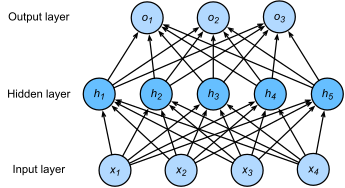



###  PyTorch的默认随机初始化

随机初始化模型参数的方法有很多。在线性回归的简洁实现中，我们使用`torch.nn.init.normal_()`使模型`net`的权重参数采用正态分布的随机初始化方式。不过，PyTorch中`nn.Module`的模块参数都采取了较为合理的初始化策略（不同类型的layer具体采样的哪一种初始化方法的可参考[源代码](https://github.com/pytorch/pytorch/tree/master/torch/nn/modules)），因此一般不用我们考虑。


### Xavier随机初始化

还有一种比较常用的随机初始化方法叫作Xavier随机初始化。
假设某全连接层的输入个数为$a$，输出个数为$b$，Xavier随机初始化将使该层中权重参数的每个元素都随机采样于均匀分布


$$
U\left(-\sqrt{\frac{6}{a+b}}, \sqrt{\frac{6}{a+b}}\right).
$$


它的设计主要考虑到，模型参数初始化后，每层输出的方差不该受该层输入个数影响，且每层梯度的方差也不该受该层输出个数影响。

# 考虑环境因素

## 协变量偏移

这里我们假设，虽然输入的分布可能随时间而改变，但是标记函数，即条件分布P（y∣x）不会改变。虽然这个问题容易理解，但在实践中也容易忽视。

想想区分猫和狗的一个例子。我们的训练数据使用的是猫和狗的真实的照片，但是在测试时，我们被要求对猫和狗的卡通图片进行分类。

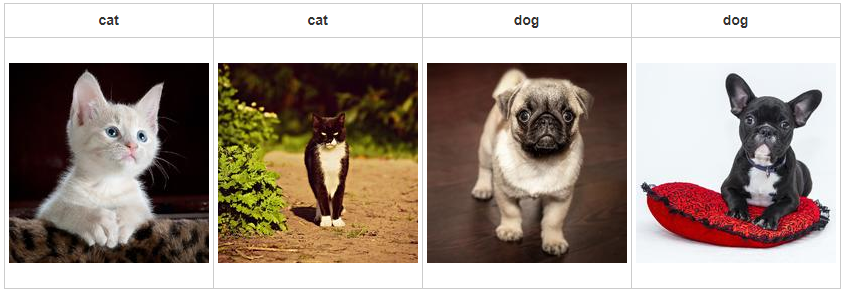







测试数据：

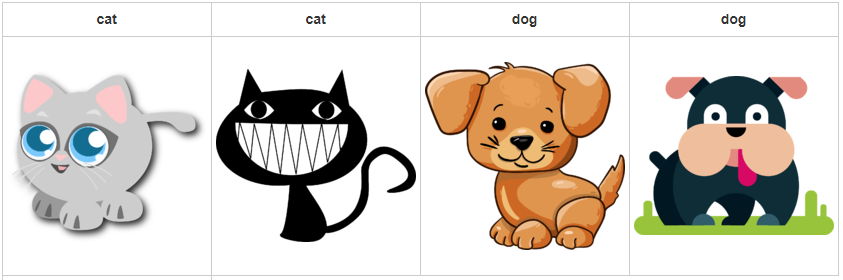

显然，这不太可能奏效。训练集由照片组成，而测试集只包含卡通。在一个看起来与测试集有着本质不同的数据集上进行训练，而不考虑如何适应新的情况，这是不是一个好主意。不幸的是，这是一个非常常见的陷阱。

统计学家称这种协变量变化是因为问题的根源在于特征分布的变化（即协变量的变化）。数学上，我们可以说P（x）改变了，但P（y∣x）保持不变。尽管它的有用性并不局限于此，当我们认为x导致y时，协变量移位通常是正确的假设。


## 标签偏移

    
当我们认为导致偏移的是标签P（y）上的边缘分布的变化，但类条件分布是不变的P（x∣y）时，就会出现相反的问题。当我们认为y导致x时，标签偏移是一个合理的假设。例如，通常我们希望根据其表现来预测诊断结果。在这种情况下，我们认为诊断引起的表现，即疾病引起的症状。有时标签偏移和协变量移位假设可以同时成立。例如，当真正的标签函数是确定的和不变的，那么协变量偏移将始终保持，包括如果标签偏移也保持。有趣的是，当我们期望标签偏移和协变量偏移保持时，使用来自标签偏移假设的方法通常是有利的。这是因为这些方法倾向于操作看起来像标签的对象，这（在深度学习中）与处理看起来像输入的对象（在深度学习中）相比相对容易一些。

病因（要预测的诊断结果）导致 症状（观察到的结果）。  

训练数据集，数据很少只包含流感p(y)的样本。  

而测试数据集有流感p(y)和流感q(y)，其中不变的是流感症状p(x|y)。

## 概念偏移

另一个相关的问题出现在概念转换中，即标签本身的定义发生变化的情况。这听起来很奇怪，毕竟猫就是猫。的确，猫的定义可能不会改变，但我们能不能对软饮料也这么说呢？事实证明，如果我们周游美国，按地理位置转移数据来源，我们会发现，即使是如图所示的这个简单术语的定义也会发生相当大的概念转变。


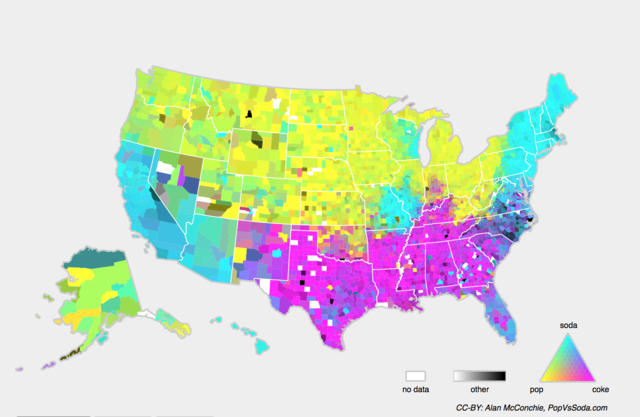

$$
美国软饮料名称的概念转变 
$$
如果我们要建立一个机器翻译系统，分布P（y∣x）可能因我们的位置而异。这个问题很难发现。另一个可取之处是P（y∣x）通常只是逐渐变化。

# Kaggle 房价预测实战

作为深度学习基础篇章的总结，我们将对本章内容学以致用。下面，让我们动手实战一个Kaggle比赛：房价预测。本节将提供未经调优的数据的预处理、模型的设计和超参数的选择。我们希望读者通过动手操作、仔细观察实验现象、认真分析实验结果并不断调整方法，得到令自己满意的结果。

In [3]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append("/home/kesci/input")
import d2lzh1981 as d2l
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.3.0


## 获取和读取数据集

比赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房子的特征，如街道类型、建造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚至是缺失值“na”。只有训练数据集包括了每栋房子的价格，也就是标签。我们可以访问比赛网页，点击“Data”标签，并下载这些数据集。

我们将通过`pandas`库读入并处理数据。在导入本节需要的包前请确保已安装`pandas`库。
假设解压后的数据位于`/home/kesci/input/houseprices2807/`目录，它包括两个csv文件。下面使用`pandas`读取这两个文件。

In [6]:
test_data = pd.read_csv("/home/kesci/input/houseprices2807/house-prices-advanced-regression-techniques/test.csv")
train_data = pd.read_csv("/home/kesci/input/houseprices2807/house-prices-advanced-regression-techniques/train.csv")

训练数据集包括1460个样本、80个特征和1个标签。

In [7]:
train_data.shape

(1460, 81)

测试数据集包括1459个样本和80个特征。我们需要将测试数据集中每个样本的标签预测出来。

In [8]:
test_data.shape

(1459, 80)

让我们来查看前4个样本的前4个特征、后2个特征和标签（SalePrice）：

In [9]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可以看到第一个特征是Id，它能帮助模型记住每个训练样本，但难以推广到测试样本，所以我们不使用它来训练。我们将所有的训练数据和测试数据的79个特征按样本连结。

In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 预处理数据
我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为$\mu$，标准差为$\sigma$。那么，我们可以将该特征的每个值先减去$\mu$再除以$\sigma$得到标准化后的每个特征值。对于缺失的特征值，我们将其替换成该特征的均值。

In [11]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 标准化后，每个数值特征的均值变为0，所以可以直接用0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来将离散数值转成指示特征。举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning\_RL和MSZoning\_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning\_RL=1且MSZoning\_RM=0。

In [12]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指示特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

可以看到这一步转换将特征数从79增加到了331。

最后，通过`values`属性得到NumPy格式的数据，并转成`Tensor`方便后面的训练。

In [13]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

## 训练模型

In [14]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

下面定义比赛用来评价模型的对数均方根误差。给定预测值$\hat y_1, \ldots, \hat y_n$和对应的真实标签$y_1,\ldots, y_n$，它的定义为


$$
\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log(y_i)-\log(\hat y_i)\right)^2}.
$$


对数均方根误差的实现如下。

In [15]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        # 将小于1的值设成1，使得取对数时数值更稳定
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

下面的训练函数跟本章中前几节的不同在于使用了Adam优化算法。相对之前使用的小批量随机梯度下降，它对学习率相对不那么敏感。我们将在之后的“优化算法”一章里详细介绍它。

In [16]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay) 
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证
我们在模型选择、欠拟合和过拟合中介绍了$K$折交叉验证。它将被用来选择模型设计并调节超参数。下面实现了一个函数，它返回第`i`折交叉验证时所需要的训练和验证数据。

In [17]:
def get_k_fold_data(k, i, X, y):
    # 返回第i折交叉验证时所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

在$K$折交叉验证中我们训练$K$次并返回训练和验证的平均误差

In [18]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## 模型选择
我们使用一组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测试误差。
有时候你会发现一组参数的训练误差可以达到很低，但是在$K$折交叉验证上的误差可能反而较高。这种现象很可能是由过拟合造成的。因此，当训练误差降低时，我们要观察$K$折交叉验证上的误差是否也相应降低。

In [19]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

fold 0, train rmse 0.241365, valid rmse 0.223083
fold 1, train rmse 0.229118, valid rmse 0.267488
fold 2, train rmse 0.232072, valid rmse 0.237995
fold 3, train rmse 0.238050, valid rmse 0.218671
fold 4, train rmse 0.231004, valid rmse 0.259185
5-fold validation: avg train rmse 0.234322, avg valid rmse 0.241284


<Figure size 252x180 with 1 Axes>

# 预测并在Kaggle中提交结果
下面定义预测函数。在预测之前，我们会使用完整的训练数据集来重新训练模型，并将预测结果存成提交所需要的格式。

In [20]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)
    # sample_submission_data = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")


设计好模型并调好超参数之后，下一步就是对测试数据集上的房屋样本做价格预测。如果我们得到与交叉验证时差不多的训练误差，那么这个结果很可能是理想的，可以在Kaggle上提交结果。

In [ ]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)

希望大家自己动手完成房价预测的实现，多参与讨论。